In [20]:
%matplotlib inline

Livia - Team Brainwave

## 1. IMPORT LIBRARIES & MOUNT DRIVE


In [21]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
import torch
import torch_geometric
from torch_geometric.data import Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
import torch.nn as nn

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso


## 2. LOAD DATAFRAMES

In [18]:
from google.colab import drive
drive.mount('/content/drive')

# Data Loading Function
def load_csv(file_path, name=""):
    """Load CSV file with error handling."""
    try:
        df = pd.read_csv(file_path)
        print(f"{name} shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading {name}: {e}")
        return None

# Define file paths for Google Drive
base_path = "/content/drive/My Drive/data_test"
data_files = {
    'train_cat': 'TRAIN_CATEGORICAL.csv',
    'train_fcm': 'TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv',
    'train_quant': 'TRAIN_QUANTITATIVE.csv',
    'train_solutions': 'TRAINING_SOLUTIONS.csv',
    'test_cat': 'TEST_CATEGORICAL.csv',
    'test_quant': 'TEST_QUANTITATIVE.csv',
    'test_fcm': 'TEST_FCM.csv'
}

# Load all datasets
datasets = {}
for name, filename in data_files.items():
    file_path = os.path.join(base_path, filename)
    datasets[name] = load_csv(file_path, name)

# Check if all datasets loaded successfully
if any(df is None for df in datasets.values()):
    raise Exception("One or more datasets failed to load")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train_cat shape: (1213, 10)
train_fcm shape: (1213, 19901)
train_quant shape: (1213, 19)
train_solutions shape: (1213, 3)
test_cat shape: (304, 10)
test_quant shape: (304, 19)
test_fcm shape: (304, 19901)


## 3. MERGE NON-FCM TRAINING & TEST DATA

In [22]:
def merge_datasets(cat_df, quant_df, name=""):
    """Merge categorical and quantitative datasets."""
    merged_df = pd.merge(cat_df, quant_df, on='participant_id', how='inner')

    print(f"{name} merged shape: {merged_df.shape}")
    return merged_df


# Prepare training and test data
train_df = merge_datasets(datasets['train_cat'], datasets['train_quant'], "Training")
test_df = merge_datasets(datasets['test_cat'], datasets['test_quant'], "Test")


# Prepare features and targets
X_train = train_df.drop(columns=['participant_id'])
Y_train = datasets['train_solutions'][['ADHD_Outcome', 'Sex_F']]
participant_ids = test_df['participant_id']
X_test = test_df.drop(columns=['participant_id'])

Training merged shape: (1213, 28)
Test merged shape: (304, 28)
Training merged shape: (1213, 28)
Test merged shape: (304, 28)


## 4. PROCESS FCM DATA WITH A GNN TO GET EMBEDDINGS


In [23]:
train_FCM = datasets['train_fcm']
test_FCM  = datasets['test_fcm']

# Drop participant_id for processing but save it for merging later.
train_FCM_proc = train_FCM.drop(columns=['participant_id'])
test_FCM_proc  = test_FCM.drop(columns=['participant_id'])

# --- Convert each vector into an adjacency matrix ---
def vector_to_adjacency(vector):
    # Assumes a 200x200 symmetric matrix (excluding diagonal)
    adj_matrix = np.zeros((200, 200))
    triu_indices = np.triu_indices(200, k=1)
    adj_matrix[triu_indices] = vector
    adj_matrix += adj_matrix.T
    return adj_matrix

# Compute adjacency matrices (each row in train_FCM_proc is converted)
adj_matrices_train = np.array([vector_to_adjacency(row) for row in train_FCM_proc.to_numpy()])
adj_matrices_test  = np.array([vector_to_adjacency(row) for row in test_FCM_proc.to_numpy()])

# --- Convert adjacency matrix to edge list for PyG ---
def adjacency_to_edge_list(adj_matrix, threshold=0.1):
    edge_index = np.array(np.where(adj_matrix > threshold))
    edge_weight = adj_matrix[edge_index[0], edge_index[1]]
    return torch.tensor(edge_index, dtype=torch.long), torch.tensor(edge_weight, dtype=torch.float)

edge_data_train = [adjacency_to_edge_list(adj) for adj in adj_matrices_train]
edge_indices_train = [data[0] for data in edge_data_train]
edge_weights_train = [data[1] for data in edge_data_train]

edge_data_test = [adjacency_to_edge_list(adj) for adj in adj_matrices_test]
edge_indices_test = [data[0] for data in edge_data_test]
edge_weights_test = [data[1] for data in edge_data_test]

# --- Create PyG graph objects ---
# Use an identity matrix for node features (each graph has 200 nodes)
graphs_train = [Data(x=torch.eye(200), edge_index=e_idx, edge_attr=e_wt)
                for e_idx, e_wt in zip(edge_indices_train, edge_weights_train)]
graphs_test  = [Data(x=torch.eye(200), edge_index=e_idx, edge_attr=e_wt)
                for e_idx, e_wt in zip(edge_indices_test, edge_weights_test)]

# --- Define a simple GCN to extract graph embeddings ---
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        # Global pooling to get graph-level embedding
        x = global_mean_pool(x, batch)  # shape: [num_graphs, hidden_channels]
        return x

# Instantiate the model; here we use 200 input channels and output a 64-dim embedding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_gcn = GCN(in_channels=200, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model_gcn.parameters(), lr=0.001)

# --- Train the GCN (for demonstration, we train for a few epochs with a dummy loss) ---
model_gcn.train()
batch_train = Batch.from_data_list(graphs_train).to(device)
for epoch in range(20):  # Adjust epochs as needed
    optimizer.zero_grad()
    embeddings = model_gcn(batch_train)  # shape: [num_train, 64]
    loss = embeddings.norm()  # dummy loss; in practice, use a proper unsupervised loss or pre-trained model
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"GCN Epoch {epoch}, loss: {loss.item():.4f}")
model_gcn.eval()
with torch.no_grad():
    embeddings_train = model_gcn(batch_train)  # tensor shape: [num_train, 64]
    batch_test = Batch.from_data_list(graphs_test).to(device)
    embeddings_test = model_gcn(batch_test)    # tensor shape: [num_test, 64]

# Convert embeddings to numpy arrays
embeddings_train_np = embeddings_train.cpu().numpy()
embeddings_test_np = embeddings_test.cpu().numpy()

# Create DataFrames for embeddings with participant_id
df_embeddings_train = pd.DataFrame(embeddings_train_np, columns=[f'GNN_feat_{i}' for i in range(64)])
df_embeddings_train['participant_id'] = train_FCM['participant_id'].values

df_embeddings_test = pd.DataFrame(embeddings_test_np, columns=[f'GNN_feat_{i}' for i in range(64)])
df_embeddings_test['participant_id'] = test_FCM['participant_id'].values

# --- Merge GNN embeddings with your previously merged data ---
train_df_with_gnn = pd.merge(train_df, df_embeddings_train, on='participant_id', how='left')
test_df_with_gnn  = pd.merge(test_df, df_embeddings_test, on='participant_id', how='left')

# Update X_train and X_test to include GNN features
X_train = train_df_with_gnn.drop(columns=['participant_id'])
X_test  = test_df_with_gnn.drop(columns=['participant_id'])


GCN Epoch 0, loss: 3.2241
GCN Epoch 5, loss: 1.1872
GCN Epoch 10, loss: 0.3686
GCN Epoch 15, loss: 0.1419


## 5. MACHINE LEARNING PIPELINE (XGBOOST with Hyperparameter Tuning)


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, make_scorer

In [25]:


# Machine Learning Pipeline
def create_preprocessor(X):
    """Create preprocessing pipeline for numeric and categorical features."""
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    return ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define custom scoring function
def multi_output_accuracy(y_true, y_pred):
    """Calculate average accuracy across multiple outputs."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean([accuracy_score(y_true[:, i], y_pred[:, i])
                   for i in range(y_true.shape[1])])

# Split training data into train and validation sets
X_train_split, X_val, Y_train_split, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

# Create and train model
preprocessor = create_preprocessor(X_train)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )))
])

# Hyperparameter tuning
param_dist = {
    'classifier__estimator__n_estimators': [50, 100, 200],
    'classifier__estimator__learning_rate': [0.01, 0.1, 0.2],
    'classifier__estimator__max_depth': [3, 5, 7],
    'classifier__estimator__subsample': [0.8, 0.9, 1.0],
    'classifier__estimator__colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform randomized search
cv = KFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring=make_scorer(multi_output_accuracy),
    random_state=42,
    n_jobs=-1,
    verbose=1
)


# Fit model and get results
search.fit(X_train, Y_train)
print("Best parameters:", search.best_params_)
print("Best cross-validation score:", search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'classifier__estimator__subsample': 0.9, 'classifier__estimator__n_estimators': 100, 'classifier__estimator__max_depth': 5, 'classifier__estimator__learning_rate': 0.01, 'classifier__estimator__colsample_bytree': 1.0}
Best cross-validation score: 0.6710505730707752


In [26]:
# Predict on validation set
Y_val_pred = search.predict(X_val)
Y_val_pred_proba = search.predict_proba(X_val)  # Probability predictions for ROC-AUC

# Extract predictions and true values for each target
Y_val_adhd, Y_val_sex = Y_val['ADHD_Outcome'], Y_val['Sex_F']
Y_pred_adhd, Y_pred_sex = Y_val_pred[:, 0], Y_val_pred[:, 1]
Y_pred_proba_adhd = [x[1] for x in Y_val_pred_proba[0]]  # Probability of positive class for ADHD
Y_pred_proba_sex = [x[1] for x in Y_val_pred_proba[1]]   # Probability of positive class for Sex_F

def print_metrics(y_true, y_pred, y_pred_proba, target_name):
    print(f"\n--- Metrics for {target_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Print metrics for each target
print_metrics(Y_val_adhd, Y_pred_adhd, Y_pred_proba_adhd, "ADHD_Outcome")
print_metrics(Y_val_sex, Y_pred_sex, Y_pred_proba_sex, "Sex_F")




--- Metrics for ADHD_Outcome ---
Accuracy: 0.687
Precision: 0.687
Recall: 1.000
F1-Score: 0.815
ROC-AUC: 0.971

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        76
           1       0.69      1.00      0.81       167

    accuracy                           0.69       243
   macro avg       0.34      0.50      0.41       243
weighted avg       0.47      0.69      0.56       243


--- Metrics for Sex_F ---
Accuracy: 0.663
Precision: 1.000
Recall: 0.012
F1-Score: 0.024
ROC-AUC: 0.937

Classification Report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.80       160
           1       1.00      0.01      0.02        83

    accuracy                           0.66       243
   macro avg       0.83      0.51      0.41       243
weighted avg       0.78      0.66      0.53       243



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


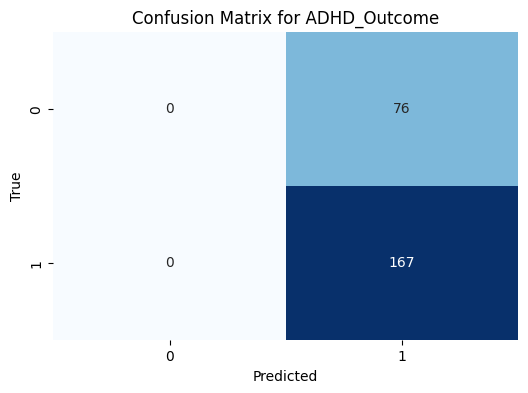

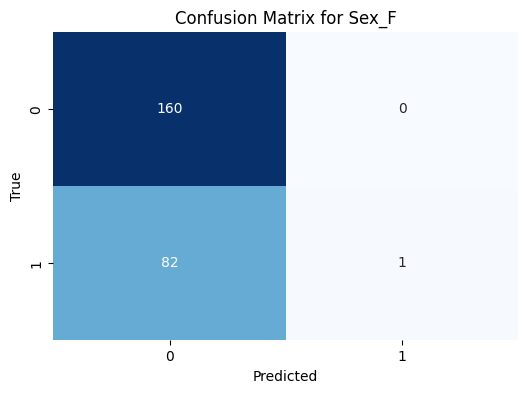

In [27]:

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, target_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {target_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(Y_val_adhd, Y_pred_adhd, "ADHD_Outcome")
plot_confusion_matrix(Y_val_sex, Y_pred_sex, "Sex_F")

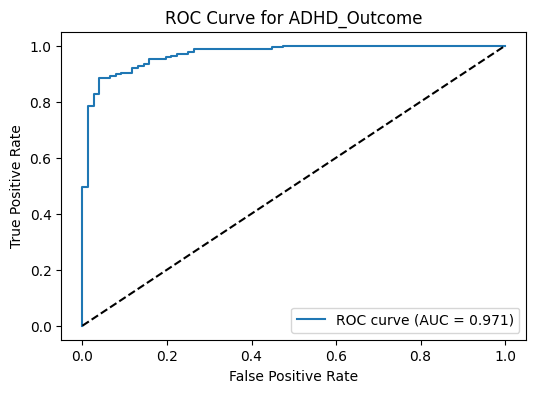

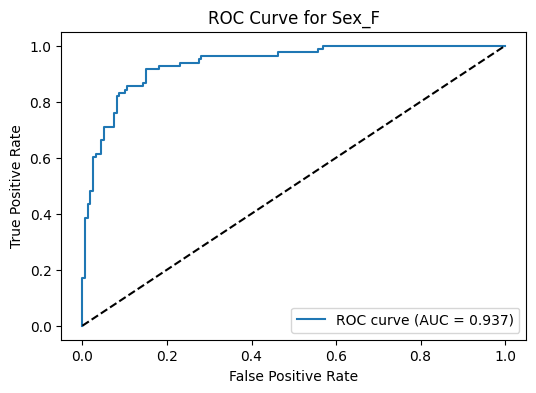

In [28]:

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, target_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_proba):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {target_name}')
    plt.legend(loc='best')
    plt.show()

# Plot ROC curves
plot_roc_curve(Y_val_adhd, Y_pred_proba_adhd, "ADHD_Outcome")
plot_roc_curve(Y_val_sex, Y_pred_proba_sex, "Sex_F")

## 6. Prediction & Submission

In [29]:
# Make predictions
y_pred = search.predict(X_test)
predictions_df = pd.DataFrame(
    y_pred,
    columns=['Predicted_ADHD', 'Predicted_Sex'],
    index=participant_ids
).reset_index()

# Save results
output_path = 'submission.csv'
predictions_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")
print(predictions_df.head())

Predictions saved to submission.csv
  participant_id  Predicted_ADHD  Predicted_Sex
0   Cfwaf5FX7jWK               1              0
1   vhGrzmvA3Hjq               1              0
2   ULliyEXjy4OV               1              0
3   LZfeAb1xMtql               1              0
4   EnFOUv0YK1RG               1              0
